# Summary

# Imports

In [1]:
import concurrent.futures
import itertools
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats

from kmtools import py_tools, sequence_tools

In [2]:
%matplotlib inline

In [3]:
pd.set_option("max_columns", 100)

# Parameters

In [4]:
NOTEBOOK_PATH = Path('validation_homology_models')
NOTEBOOK_PATH

PosixPath('validation_homology_models')

In [5]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks/validation_homology_models')

In [6]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [7]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [8]:
if DEBUG:
    NETWORK_NAME = "dcn_old_0,9c5a963"
else:
    assert NETWORK_NAME is not None

In [9]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

# `DATAPKG`

In [10]:
DATAPKG = {}

In [18]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [19]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency_net_v2", "master")
)

In [53]:
DATAPKG['hhsuite-wstructure'] = {
    'pdb_homology_modeling_part2': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
            "master",
            "pdb_homology_modeling_part2",
        ),
    'pdb_homology_modeling_rosetta_score':  
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
            "c49376c0cbbf13df565e8f7babda332b4a1b1436",
            "pdb_homology_modeling_rosetta_score",
        ),
}

# Network evaluation

In [54]:
%run trained_networks.ipynb

In [55]:
def predict_with_dcn_old(input_, network_info, network_state):
    from pagnn.prediction.dcn_old import Args, main
    for adj_col in ['adjacency_idx_1', 'adjacency_idx_2']:
        input_[adj_col] = input_.apply(lambda row: np.r_[row[adj_col], 0:len(row['sequence'])], axis=1).values
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

In [56]:
def predict_with_dcn(input_, network_info, network_state):
    from pagnn.prediction.dcn import Args, main
    args = Args(network_info=network_info, network_state=network_state)
    output_df = main(args, input_)
    return output_df

# Load data

## `pdb_homology_modeling`

In [57]:
homology_model_files = sorted(
    DATAPKG['hhsuite-wstructure']['pdb_homology_modeling_part2']
    .glob('*-???.parquet')
)

assert len(homology_model_files) == 10
homology_model_files[:3]

[PosixPath('/home/kimlab1/database_data/datapkg_output_dir/hhsuite-wstructure/master/pdb_homology_modeling_part2/uniprot20_2016_02-pdb70-001.parquet'),
 PosixPath('/home/kimlab1/database_data/datapkg_output_dir/hhsuite-wstructure/master/pdb_homology_modeling_part2/uniprot20_2016_02-pdb70-002.parquet'),
 PosixPath('/home/kimlab1/database_data/datapkg_output_dir/hhsuite-wstructure/master/pdb_homology_modeling_part2/uniprot20_2016_02-pdb70-003.parquet')]

In [58]:
columns = [
    "unique_id", "query_id",
    "sequence",
    "adjacency_idx_1_from_pdb", "adjacency_idx_2_from_pdb", 
    "adjacency_idx_1_from_hm", "adjacency_idx_2_from_hm", 
    'hm_residue_idx_1', 'hm_residue_idx_2',
    'dope_score', "ga341_score", "dope_score_norm", "molpdf",
    
    "score", "similarity", "sum_probs",
    "evalue", "probability", "identity", "coverage",
    
    "identity_calc",

    'query_ali', 'template_ali',
    "query_match_length", "template_match_length",
]

dfs = []
for i, file in enumerate(homology_model_files):
    task_id = i + 1
    assert f"{task_id:03}" in file.as_posix()
    df = pq.read_table(file, columns=columns, use_pandas_metadata=True).to_pandas(integer_object_nulls=True)
    df['task_id'] = task_id
    dfs.append(df)

homology_model_scores = pd.concat(dfs).reset_index()

In [59]:
homology_model_scores.head(2)

,index,unique_id,query_id,sequence,adjacency_idx_1_from_pdb,adjacency_idx_2_from_pdb,adjacency_idx_1_from_hm,adjacency_idx_2_from_hm,hm_residue_idx_1,hm_residue_idx_2,dope_score,ga341_score,dope_score_norm,molpdf,score,similarity,sum_probs,evalue,probability,identity,coverage,query_ali,template_ali,query_match_length,template_match_length,task_id
0,0,33091-5IM6_P-1-143,33091,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 114, 0, 2, 3, 4, 5, 6, 110, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 112, 113, 0, 2, 3, 4, 5, 6, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 113, 114, 0, 2, 3, 4, 5, 6, 11...",-15450.600586,1.0,-1.219322,631.898438,271.19,0.528,131.8,7.100000e-45,100.0,0.35,1.0,WKDSPIIEANGTLDELTSFIGEAKHYVD-EEMKGILEEIQNDIYKI...,MGDDARIAAIGDVDELNSQIGVLLAEPLPDDVRAALSAIQHDLFDL...,142,143,1
1,1,33091-3KE5_A-41-189,33091,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, ...","[1, 2, 3, 6, 0, 2, 3, 6, 7, 0, 1, 3, 4, 7, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[1, 2, 3, 6, 0, 2, 3, 6, 7, 0, 1, 3, 4, 6, 7, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[1, 2, 3, 6, 0, 2, 3, 6, 7, 0, 1, 3, 4, 6, 7, ...",-15252.435547,1.0,-1.120488,1419.512695,270.51,0.533,131.6,9.500000e-45,100.0,0.36,1.0,WKDSPIIEANGTLDELTSFIGEAKHYVDE----EMKGILEEIQNDI...,DKDDIRVEAYGTIDEANSHIGYAMTKLQGGAFIDIYNELENIQHEL...,142,149,1


In [ ]:
for query_id, group in output_succeeded_df.groupby('query_id'):
    assert (group['query_match_length'] == group['query_match_length'].iloc[0]).all()

In [60]:
print(len(homology_model_scores))
print(len(homology_model_scores[['index']].drop_duplicates()))
print(len(homology_model_scores[['index', 'task_id']].drop_duplicates()))

129667
13365
129667


In [61]:
homology_model_scores[homology_model_scores.index != homology_model_scores['index']].head(2)

,index,unique_id,query_id,sequence,adjacency_idx_1_from_pdb,adjacency_idx_2_from_pdb,adjacency_idx_1_from_hm,adjacency_idx_2_from_hm,hm_residue_idx_1,hm_residue_idx_2,dope_score,ga341_score,dope_score_norm,molpdf,score,similarity,sum_probs,evalue,probability,identity,coverage,query_ali,template_ali,query_match_length,template_match_length,task_id
13365,0,84392135-2GF0_B-68-170,84392135,KIQEKVDRALEDAEVVLFAVDGRAELTQADYEVAEYLRRKGKPVIL...,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...","[1, 2, 4, 5, 8, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...","[1, 2, 4, 5, 8, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...","[1, 2, 4, 5, 8, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, ...",-7805.654297,1.0,-0.312216,1690.184082,74.7,0.138,64.9,4.900000e-09,98.35,0.12,1.0,KIQEKVDRALEDAEVVLFAVDGRAELTQAD-YEVAEYLRR-----K...,QFPAMQRLSISKGHAFILVFSVTSKQSLEELGPIYKLIVQIKGSVE...,94,103,2
13366,1,84392135-2GF0_C-68-170,84392135,KIQEKVDRALEDAEVVLFAVDGRAELTQADYEVAEYLRRKGKPVIL...,"[0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, ...","[1, 2, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 6, 35,...","[0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, ...","[1, 2, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 6, 1, ...","[0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, ...","[1, 2, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 6, 1, ...",-7662.851562,1.0,-0.204626,2368.135010,74.7,0.138,64.9,4.900000e-09,98.35,0.12,1.0,KIQEKVDRALEDAEVVLFAVDGRAELTQAD-YEVAEYLRR-----K...,QFPAMQRLSISKGHAFILVFSVTSKQSLEELGPIYKLIVQIKGSVE...,94,103,2


## `rosetta_scores`

In [62]:
rosetta_scores_files = sorted(
    DATAPKG['hhsuite-wstructure']['pdb_homology_modeling_rosetta_score']
    .glob('*-???-?.parquet')
)

assert len(rosetta_scores_files) == 100
rosetta_scores_files[:3]

[PosixPath('/home/kimlab1/database_data/datapkg_output_dir/hhsuite-wstructure/c49376c0cbbf13df565e8f7babda332b4a1b1436/pdb_homology_modeling_rosetta_score/uniprot20_2016_02-pdb70-001-0.parquet'),
 PosixPath('/home/kimlab1/database_data/datapkg_output_dir/hhsuite-wstructure/c49376c0cbbf13df565e8f7babda332b4a1b1436/pdb_homology_modeling_rosetta_score/uniprot20_2016_02-pdb70-001-1.parquet'),
 PosixPath('/home/kimlab1/database_data/datapkg_output_dir/hhsuite-wstructure/c49376c0cbbf13df565e8f7babda332b4a1b1436/pdb_homology_modeling_rosetta_score/uniprot20_2016_02-pdb70-001-2.parquet')]

In [63]:
dfs = []
for i, file in enumerate(rosetta_scores_files):
    task_id = i // 10 + 1
    assert f"{task_id:03}" in file.as_posix()
    df = pq.read_table(file, use_pandas_metadata=True).to_pandas(integer_object_nulls=True)
    df['task_id'] = task_id
    dfs.append(df)

rosetta_scores = pd.concat(dfs).reset_index()

In [64]:
rosetta_scores.head(2)

,index,error,rosetta_dslf_fa13,rosetta_fa_atr,rosetta_fa_dun,rosetta_fa_elec,rosetta_fa_intra_rep,rosetta_fa_intra_sol_xover4,rosetta_fa_rep,rosetta_fa_sol,rosetta_hbond_bb_sc,rosetta_hbond_lr_bb,rosetta_hbond_sc,rosetta_hbond_sr_bb,rosetta_linear_chainbreak,rosetta_lk_ball_wtd,rosetta_omega,rosetta_overlap_chainbreak,rosetta_p_aa_pp,rosetta_pro_close,rosetta_rama_prepro,rosetta_ref,rosetta_score,rosetta_time,rosetta_total_score,rosetta_yhh_planarity,task_id
0,0,None,0.0,-859.704,185.429,-244.253,1.919,25.885,123.453,586.188,-11.718,0.0,-13.887,-101.370,0.0,-24.345,7.339,0.0,-14.961,0.190,19.523,43.337,-276.913,0.0,-276.913,0.064,1
1,1,None,0.0,-839.741,183.997,-283.734,1.965,27.730,122.678,560.051,-8.639,0.0,-11.660,-98.922,0.0,-24.753,2.366,0.0,-13.643,0.048,3.469,43.337,-335.384,0.0,-335.384,0.070,1


In [145]:
print(len(rosetta_scores))
print(len(rosetta_scores[['index']].drop_duplicates()))
print(len(rosetta_scores[['index', 'task_id']].drop_duplicates()))

129166
14951
129166


## `homology_models_dataset`

In [146]:
homology_models_dataset = homology_model_scores.merge(rosetta_scores, on=['index', 'task_id'])

In [147]:
print(len(homology_models_dataset))
print(len(homology_models_dataset[['index']].drop_duplicates()))
print(len(homology_models_dataset[['index', 'task_id']].drop_duplicates()))

113416
13357
113416


In [148]:
homology_models_dataset['identity_calc'] = homology_models_dataset.apply(
    lambda row: 
        sum(a == b for a, b in zip(row['query_ali'], row['template_ali']) if a != '-') /
        len(row['query_ali'].replace('-', '')),
    axis=1,
)
# assert all((scop40_hhsearch_all_hits['identity_calc'] - scop40_hhsearch_all_hits['identity']).abs() < 0.1)

In [149]:
print(len(homology_models_dataset))
print(len(homology_models_dataset[['index']].drop_duplicates()))
print(len(homology_models_dataset[['index', 'task_id']].drop_duplicates()))

113416
13357
113416


## Statistics

In [150]:
display(homology_models_dataset.head(2))
print(len(homology_models_dataset))
print(len(set(homology_models_dataset['query_id'])))

,index,unique_id,query_id,sequence,adjacency_idx_1_from_pdb,adjacency_idx_2_from_pdb,adjacency_idx_1_from_hm,adjacency_idx_2_from_hm,hm_residue_idx_1,hm_residue_idx_2,dope_score,ga341_score,dope_score_norm,molpdf,score,similarity,sum_probs,evalue,probability,identity,coverage,query_ali,template_ali,query_match_length,template_match_length,task_id,error,rosetta_dslf_fa13,rosetta_fa_atr,rosetta_fa_dun,rosetta_fa_elec,rosetta_fa_intra_rep,rosetta_fa_intra_sol_xover4,rosetta_fa_rep,rosetta_fa_sol,rosetta_hbond_bb_sc,rosetta_hbond_lr_bb,rosetta_hbond_sc,rosetta_hbond_sr_bb,rosetta_linear_chainbreak,rosetta_lk_ball_wtd,rosetta_omega,rosetta_overlap_chainbreak,rosetta_p_aa_pp,rosetta_pro_close,rosetta_rama_prepro,rosetta_ref,rosetta_score,rosetta_time,rosetta_total_score,rosetta_yhh_planarity,identity_calc
0,0,33091-5IM6_P-1-143,33091,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 114, 0, 2, 3, 4, 5, 6, 110, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 112, 113, 0, 2, 3, 4, 5, 6, 11...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1, 2, 3, 4, 5, 113, 114, 0, 2, 3, 4, 5, 6, 11...",-15450.600586,1.0,-1.219322,631.898438,271.19,0.528,131.8,7.100000e-45,100.0,0.35,1.0,WKDSPIIEANGTLDELTSFIGEAKHYVD-EEMKGILEEIQNDIYKI...,MGDDARIAAIGDVDELNSQIGVLLAEPLPDDVRAALSAIQHDLFDL...,142,143,1,None,0.0,-860.382,183.795,-240.048,1.974,28.464,120.777,582.609,-6.196,0.0,-16.363,-102.818,0.0,-25.985,5.658,0.0,-14.138,0.160,19.581,43.337,-279.537,0.0,-279.537,0.037,0.345070
1,1,33091-3KE5_A-41-189,33091,WKDSPIIEANGTLDELTSFIGEAKHYVDEEMKGILEEIQNDIYKIM...,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, ...","[1, 2, 3, 6, 0, 2, 3, 6, 7, 0, 1, 3, 4, 7, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[1, 2, 3, 6, 0, 2, 3, 6, 7, 0, 1, 3, 4, 6, 7, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...","[1, 2, 3, 6, 0, 2, 3, 6, 7, 0, 1, 3, 4, 6, 7, ...",-15252.435547,1.0,-1.120488,1419.512695,270.51,0.533,131.6,9.500000e-45,100.0,0.36,1.0,WKDSPIIEANGTLDELTSFIGEAKHYVDE----EMKGILEEIQNDI...,DKDDIRVEAYGTIDEANSHIGYAMTKLQGGAFIDIYNELENIQHEL...,142,149,1,None,0.0,-833.286,186.272,-284.943,1.974,28.374,117.291,560.683,-10.367,0.0,-15.017,-98.689,0.0,-24.205,1.919,0.0,-13.503,0.061,1.482,43.337,-338.518,0.0,-338.518,0.100,0.359155


113416
6444


In [151]:
def hist(col, range, *args, **kwargs):
    x = homology_models_dataset[col]
    x = np.clip(x, *range)
    with plt.rc_context(rc={"font.size": 12}):
        plt.hist(x, range=range, **kwargs)
        plt.title(col)

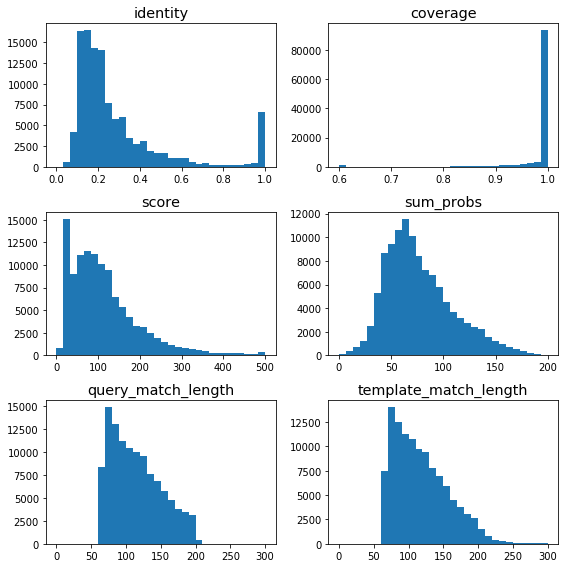

In [152]:
fg, axs = plt.subplots(3, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
hist("identity", range=(0, 1), bins=30)

plt.sca(axs[0, 1])
hist("coverage", range=(0.6, 1), bins=30)

plt.sca(axs[1, 0])
hist("score", range=(0, 500), bins=30)

plt.sca(axs[1, 1])
hist("sum_probs", range=(0, 200), bins=30)

plt.sca(axs[2, 0])
hist("query_match_length", range=(0, 300), bins=30)

plt.sca(axs[2, 1])
hist("template_match_length", range=(0, 300), bins=30)

plt.tight_layout()

## Validation

In [155]:
homology_models_dataset["frac_aa_wadj_pdb"] = (
    homology_models_dataset["adjacency_idx_1_from_pdb"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

homology_models_dataset["frac_aa_wadj_hm"] = (
    homology_models_dataset["adjacency_idx_1_from_hm"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

homology_models_dataset["frac_aa_wadj_hm2"] = (
    homology_models_dataset["hm_residue_idx_1"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

Text(0.5,0,'frac_aa_wadj_hm2')

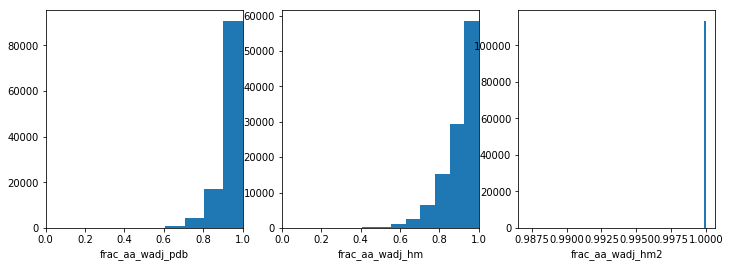

In [165]:
fg, axs = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axs[0])
_ = plt.hist(homology_models_dataset["frac_aa_wadj_pdb"])
plt.xlim(0, 1)
plt.xlabel("frac_aa_wadj_pdb")

plt.sca(axs[1])
_ = plt.hist(homology_models_dataset["frac_aa_wadj_hm"])
plt.xlim(0, 1)
plt.xlabel("frac_aa_wadj_hm")

plt.sca(axs[2])
_ = plt.hist(homology_models_dataset["frac_aa_wadj_hm2"], bins=100)
# plt.xlim(0, 1.1)
plt.xlabel("frac_aa_wadj_hm2")

In [32]:
def validate_adjacency_df(df, adj_column_1, adj_column_2):
    assert (df[adj_column_1].apply(min) >= 0).all()
    assert (df[adj_column_2].apply(min) >= 0).all()
    
    assert (
        df[adj_column_1].apply(max) <
        df['sequence'].str.len()
    ).all()

    assert (
        df[adj_column_2].apply(max) <
        df['sequence'].str.len()
    ).all()

    assert (
        (df[adj_column_1].apply(lambda l: len(set(l))) /
         df['sequence'].str.len()) > 0.5
    ).all()

    assert (
        (df[adj_column_2].apply(lambda l: len(set(l))) /
         df['sequence'].str.len()) > 0.5
    ).all()
    
    
# validate_adjacency_df(homology_models_dataset, "adjacency_idx_1_from_pdb", "adjacency_idx_2_from_pdb")
# validate_adjacency_df(homology_models_dataset, "adjacency_idx_1_from_hm", "adjacency_idx_2_from_hm")b

In [33]:
raise Exception

Exception: 

In [89]:
def plot(df, columns):
    
    mat = np.zeros((len(columns), len(columns)), float)
    for i, c1 in enumerate(columns):
        for j, c2 in enumerate(columns):
            x = df[c1] if 'dope' not in c1 else -df[c1]
            y = df[c2] if 'dope' not in c2 else -df[c2]
            mat[i, j] = stats.spearmanr(x, y)[0]

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(mat)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(columns)):
        for j in range(len(columns)):
            text = ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center", color="w")

    ax.set_title("Harvest of local farmers (in tons/year)")
    fig.tight_layout()
    plt.show()

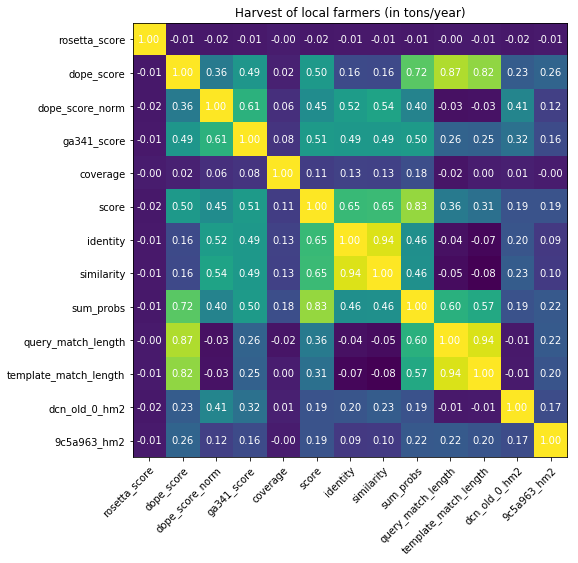

In [171]:
columns = [
    'rosetta_score',
    'dope_score', 'dope_score_norm', 'ga341_score',
    
    "coverage", 
#     "identity",
    "score",  # "probability", "evalue",
    "identity", "similarity", "sum_probs",
    "query_match_length", "template_match_length",
]    + [
        f"{network_name}{suffix}"
        for network_name in NETWORK_NAME.split(',')
        for suffix in [
#             "_pdb",
#             "_hm",
            "_hm2",
        ]
    ]


plot(homology_models_dataset, columns)

In [172]:
homology_models_dataset['query_seq'] = (
    homology_models_dataset['query_ali'].str.replace('-', '')
)

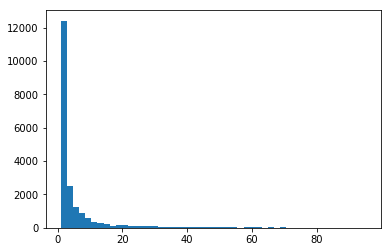

In [173]:
_ = plt.hist([len(x[1]) for x in homology_models_dataset.groupby('query_seq')], bins=50)

In [185]:
target_columns = ['rosetta_score', 'dope_score', 'dope_score_norm', 'ga341_score']

feature_columns = [
    "coverage", 
#     "identity",
    "score",  # "probability", "evalue",
    "identity", "similarity", "sum_probs",
    "query_match_length", "template_match_length",
] + [
    f"{network_name}{suffix}"
    for network_name in NETWORK_NAME.split(',')
    for suffix in [
#         "_pdb",
#         "_hm",
        "_hm2",
    ]
]

correlations = {y_col: {x_col: [] for x_col in feature_columns} for y_col in target_columns}

for query_id, group in homology_models_dataset.groupby('query_seq'):
    if len(group) > 3:
        for y_col in target_columns:
            for x_col in feature_columns:
                df = group.dropna(subset=[x_col, y_col])
                if len(df) < 3 or len(set(df[x_col])) == 1 or len(set(df[y_col])) == 1:
                    continue
                corr, pvalue = stats.spearmanr(df[x_col], df[y_col])
                correlations[y_col][x_col].append(corr)

rosetta_score


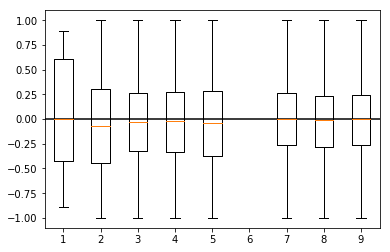

dope_score


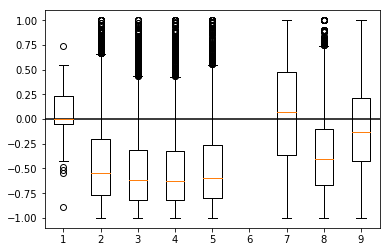

dope_score_norm


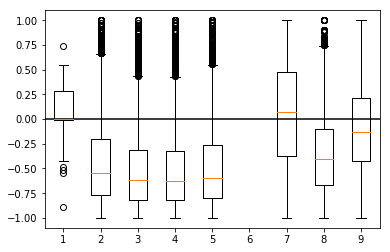

ga341_score


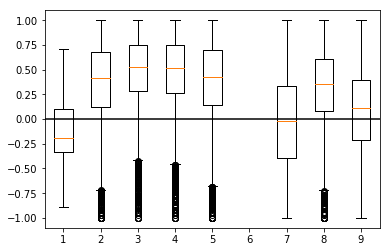

In [186]:
for k in target_columns:
    print(k)
    _ = plt.boxplot([correlations[k][f] for f in correlations['rosetta_score']])
    plt.hlines(0, 0.5, 9.6)
    plt.show()

In [ ]:
_ = plt.boxplot([correlations['rosetta_score'][f] for f in correlations['rosetta_score']])

# Predictions

In [ ]:
%run trained_networks.ipynb

## Run network

### Predictions using PDB adjacencies

In [ ]:
input_df = homology_models_dataset.copy()

input_df['adjacency_idx_1'] = input_df[f'adjacency_idx_1_from_pdb']
input_df['adjacency_idx_2'] = input_df[f'adjacency_idx_2_from_pdb']

for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    homology_models_dataset[f'{network_name}_pdb'] = (
        predict_with_network(
            input_df.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

### Predictions using HM adjacencies

In [ ]:
input_df = homology_models_dataset.copy()

input_df['adjacency_idx_1'] = input_df[f'adjacency_idx_1_from_hm']
input_df['adjacency_idx_2'] = input_df[f'adjacency_idx_2_from_hm']

for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    homology_models_dataset[f'{network_name}_hm'] = (
        predict_with_network(
            input_df.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

In [166]:
input_df = homology_models_dataset.copy()

input_df['adjacency_idx_1'] = input_df[f'hm_residue_idx_1']
input_df['adjacency_idx_2'] = input_df[f'hm_residue_idx_2']

for network_name in NETWORK_NAME.split(','):
    predict_with_network = predict_with_dcn_old if 'dcn_old' in network_name else predict_with_dcn
    homology_models_dataset[f'{network_name}_hm2'] = (
        predict_with_network(
            input_df.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

Network name: 'DCN_9c5a963'
Final output_channels: 256


## Make plot

In [179]:
cmap = plt.cm.get_cmap('Set1', 10)

In [180]:
target = 'dope_score'

features = (
    [
        "identity", "coverage", 
        "score",  # "probability", "evalue",
        "identity", "similarity", "sum_probs",
    ]
    + [
        f"{network_name}{suffix}"
        for network_name in NETWORK_NAME.split(',')
        for suffix in [
#             "_pdb",
#             "_hm",
            "_hm2"
        ]
    ]
)

DATA = {}
for target in ['dope_score', 'dope_score_norm', 'ga341_score', 'rosetta_score']:
    data = []
    for feature in features:
        df = homology_models_dataset[[feature, target]].dropna()
        corr = stats.spearmanr(df[feature], df[target])
        data.append((feature, corr.correlation, corr.pvalue))
    DATA[target] = pd.DataFrame(data, columns=['feature', 'correlation', 'pvalue'])

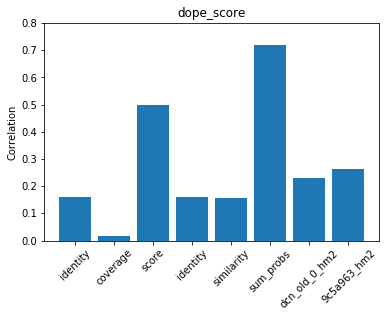

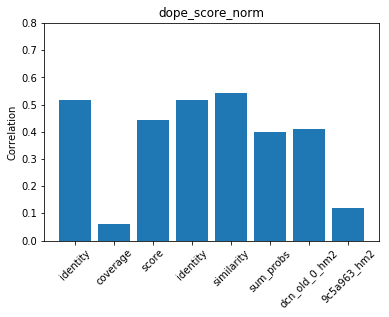

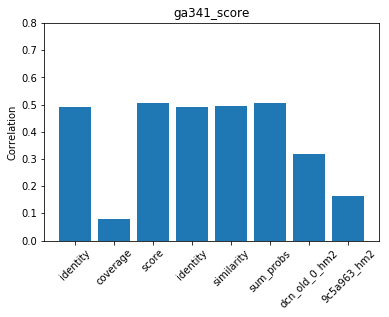

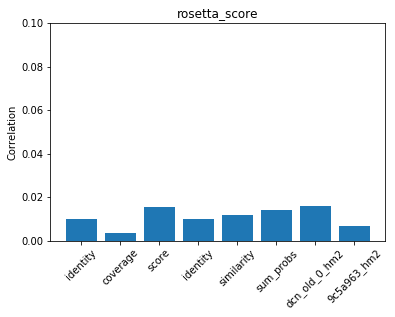

In [181]:
for target, df in DATA.items():
    x = np.arange(len(df))
#     c = [cmap(1) if c >= 0 else cmap(0) for c in df['correlation']]
    plt.bar(x, df['correlation'].abs())
    plt.xticks(x, df['feature'], rotation=45)
    if target == "rosetta_score":
        plt.ylim(0, 0.1)
    else:
        plt.ylim(0, 0.8)
    plt.ylabel("Correlation")
    plt.title(f"{target}")
    plt.show()

In [ ]:
homology_models_dataset['rosetta_score'].hist(range=(-1000, 1000))

In [ ]:
def plot(col1, col2):
    df = homology_models_dataset[[col1, col2]].dropna()
    if len(df) != len(homology_models_dataset):
        print(f"Removed {len(homology_models_dataset) - len(df)} columns with nulls!")
    x = df[col1]
    y = df[col2]
    corr = stats.spearmanr(x, y)
    plt.plot(x, y, 'rx')
    plt.title(f"{corr.correlation:.3f} ({corr.pvalue:.3f})")
    plt.xlabel(col1)
    plt.ylabel(col2)

In [ ]:
plot('rosetta_score', 'dcn_old_0_pdb')

In [ ]:
plot('dope_score_norm', 'network_pred_pdb')

In [ ]:
plot('ga341_score', 'network_pred_pdb')